# Geospatial Analysis of Environmental Drivers and Red Tide Risk

In [2]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

#  Suppress warnings issued by Cartopy when downloading data files
import warnings
warnings.filterwarnings('ignore')

## 1. Create Base Map Location

This section sets up a global base map using the Cartopy library with a Plate Carrée projection centered around longitude -75. It includes natural Earth features like coastlines, rivers, and state boundaries to provide geographic context. The map serves as the foundational layer for further spatial visualizations and is focused on the Southwest Florida region.

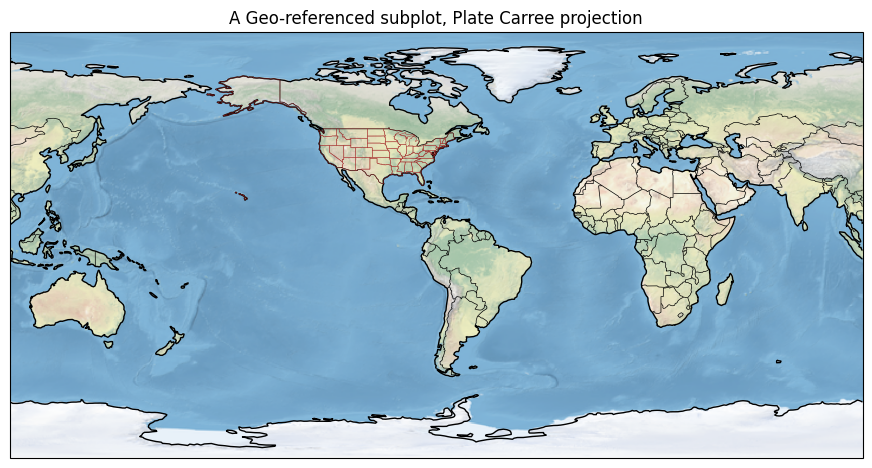

In [3]:
# Create a figure with a specified size
fig = plt.figure(figsize=(11, 8.5))

# Add a subplot with PlateCarree projection
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-75))
ax.set_title("A Geo-referenced subplot, Plate Carree projection")

# Method 1 for pre-defined features of Natural Earth datasets
ax.coastlines(resolution='110m', color='black')

# Adding borders and states to the plot
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')

#Add the only pre-created background image in CartoPy
ax.stock_img()

## 2. Refine Region to Southwest Florida and Gulf of America

This section zooms in on the Gulf of Mexico and Southwest Florida by defining specific longitude and latitude boundaries. It sets the map extent and centers the plot using a Plate Carrée projection. Gridlines are added for geographic reference, providing a focused view ideal for visualizing regional environmental data.

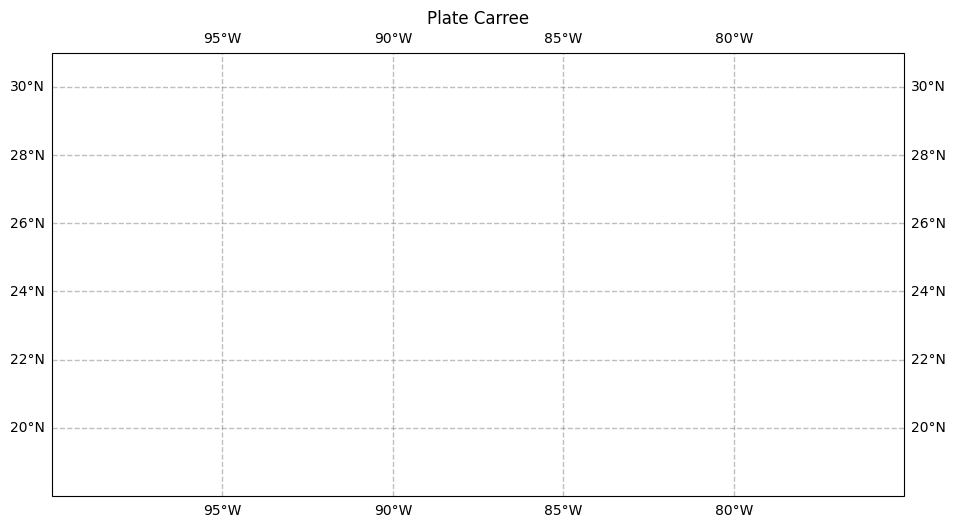

In [4]:
#Select plot extend: Lon_West, Lon_East, Lat_South, Lat_North in Degrees
extent = [-75, -100, 18, 31] 
cLon = (extent[0] + extent[1]) / 2
cLat = (extent[2] + extent[3]) / 2

#Select projection
projPC = ccrs.PlateCarree()

# Create figure and axes
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=projPC)

# Setting the extent of the plot
ax.set_extent(extent, crs=projPC)

# Add plot title and gridlines
ax.set_title('Plate Carree')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

## 3. Add Features - Coastline, Lakes, Rivers and Cities

This section enhances the regional map with detailed geographic and hydrologic features. It adds coastlines, lakes, rivers, and international borders for clearer context. Bathymetry data is visualized using color gradients to show water depth. Major cities like Tampa, Sarasota, and Naples are marked with labeled points. Together, these features create a more informative and visually rich map of the Gulf and Southwest Florida.

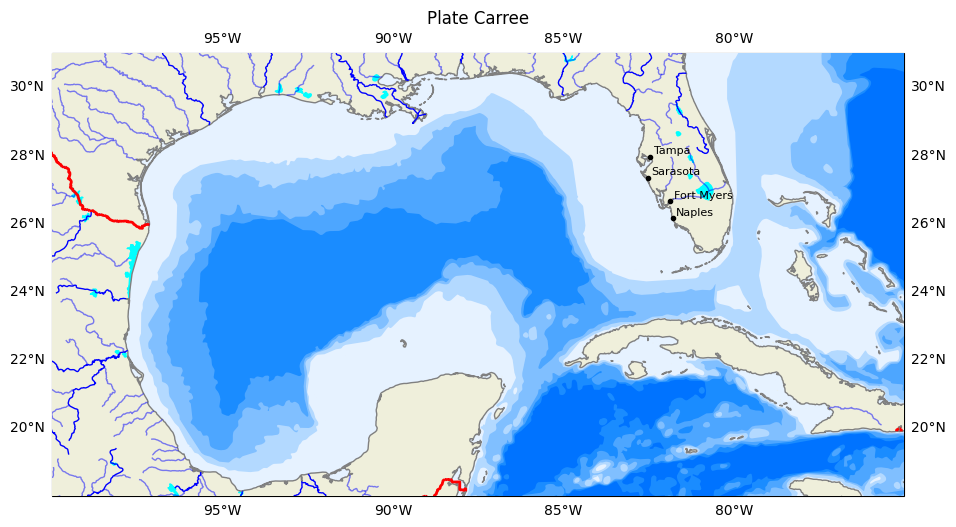

In [5]:
# Set background color to water color
ax.set_facecolor(cfeature.COLORS['water'])

# Add Land with zorder=0 meaning that feature order will be backward
ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=20) 

# Add Coastlines, and Lakes above Land features
ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=21) 
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=21) 

# Add Boarders feature on the top
ax.add_feature(cfeature.BORDERS, 
               edgecolor='red',facecolor='none', linewidth=2, zorder=22) 

# Add rivers
ax.add_feature(cfeature.NaturalEarthFeature(
    'physical',
    'rivers_lake_centerlines',
    scale='10m',
    edgecolor='blue',
    facecolor='none')
               ,zorder=21)

# Add additional for North America
ax.add_feature(cfeature.NaturalEarthFeature(
    'physical',
    'rivers_north_america',
    scale='10m',
    edgecolor='blue',
    facecolor='none',
    alpha=0.5),
               zorder=21)

# Plot 6 bathymetry lines using a loop
# Names of bathymetry line 
bathymetry_names = ['bathymetry_L_0', 'bathymetry_K_200', 
                    'bathymetry_J_1000', 'bathymetry_I_2000', 
                    'bathymetry_H_3000', 'bathymetry_G_4000'] 

# Very light blue to light blue generated by ChatGPT 3.5 Turbo
colors = [(0.9, 0.95, 1), (0.7, 0.85, 1), 
          (0.5, 0.75, 1), (0.3, 0.65, 1), 
          (0.1, 0.55, 1), (0, 0.45, 1), ]  

# Loop to plot each bathymetry line
for bathymetry_name, color in zip(bathymetry_names, colors):
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            category='physical', 
            name=bathymetry_name, 
            scale='10m', 
            edgecolor='none', 
            facecolor=color), 
        zorder = 11)

# Add names and locations of major cities
# Define markers for each location as a dictionary
locations_coordinates = {
    "Tampa": [27.9506, -82.4572],
    "Sarasota": [27.3364, -82.5307],
    "Fort Myers": [26.6406, -81.8723],
    "Naples": [26.142, -81.7948]}

# Use a loop to add markers and text labels slightly away from each other for each location 
for location, coordinates in locations_coordinates.items():
    #Plot marker
    ax.plot(coordinates[1],  # lon coordinate of locatin in Degrees
            coordinates[0],  # lat coordinate of locatin in Degrees
            transform=ccrs.PlateCarree(),  # Set coordinate system for coordinates, which is Plate Carree
            marker='o',      # Marker style for the plot
            color='black',     # Color of the markers
            markersize=3,    # Size of the markers   
            zorder = 22,  # Plot order of the feature
           )
    #Annote each city
    ax.text(coordinates[1] + 0.1,   # lon coordinate of locatin in Degrees (slightly adjusted away from marker)
            coordinates[0] + 0.1,   # lat coordinate of locatin in Degrees (slightly adjusted away from marker)
            location,               # Text to display (city name)
            transform=ccrs.PlateCarree(),   # Specify coordinate system for coordinates, which is Plate Carree
            color='black',           # Color of the text
            fontsize=8,              # Font size of the text
            zorder = 22,  # Plot order of the feature
           )

fig

## 4. Caloosahatchee River Watershed

This section defines a geospatial map of key environmental monitoring stations and geographic reference points across the Caloosahatchee River region using satellite-style basemaps. We begin by defining latitude and longitude coordinates for several locations including the S.R. 79 discharge site, nutrient monitoring stations (Bridge and Deep Lagoon), Page Field Airport (wind data), and reference markers like the Gulf of Mexico and Bob Jones Preserve.

These coordinates are converted into a GeoDataFrame using geopandas, and reprojected into Web Mercator (EPSG:3857) to align with the basemap. We then use the contextily library to overlay OpenStreetMap tiles, producing a realistic and high-resolution contextual map. Labels and markers are added for clarity.

The resulting visualization gives a spatial overview of the study region and monitoring locations used throughout the Red Tide analysis.

In [130]:
pip install geopandas contextily

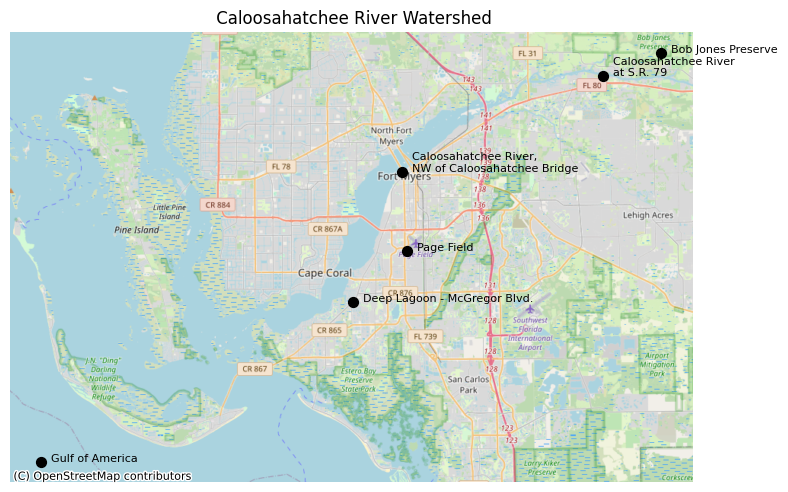

In [131]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# === Define site coordinates and convert to GeoDataFrame ===
import pandas as pd
from shapely.geometry import Point

stations = {
    "Caloosahatchee River\nat S.R. 79": (26.721, -81.693),
    "Deep Lagoon - McGregor Blvd.": (26.539, -81.918),
    "Caloosahatchee River,\nNW of Caloosahatchee Bridge": (26.644, -81.874),
    "Page Field": (26.58, -81.87),
    "Gulf of America": (26.41, -82.20),
    "Bob Jones Preserve": (26.74, -81.64)
}

gdf = gpd.GeoDataFrame({
    'Station': stations.keys(),
    'geometry': [Point(lon, lat) for lat, lon in stations.values()]
}, crs="EPSG:4326")  # WGS84

# Project to Web Mercator for contextily
gdf = gdf.to_crs(epsg=3857)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, color='black', markersize=50, zorder=10)

# Add labels
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Station']):
    ax.text(x + 1000, y, label, fontsize=8)

# Add basemap (OpenStreetMap or others)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Zoom & frame
ax.set_title(" Caloosahatchee River Watershed", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## 5. Seasonal Sea Surface Temperature (SST) Patterns in Southwest Florida

This section analyzes long-term sea surface temperature (SST) trends by loading and merging multi-decade NetCDF files using the xarray library. SST data at 0.5-meter depth are extracted, and monthly averages are calculated across all available years. The results are visualized as seasonal maps (January, June, August, and December) showing spatial SST distributions across Southwest Florida. These visualizations help identify seasonal heating patterns that may influence red tide dynamics.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


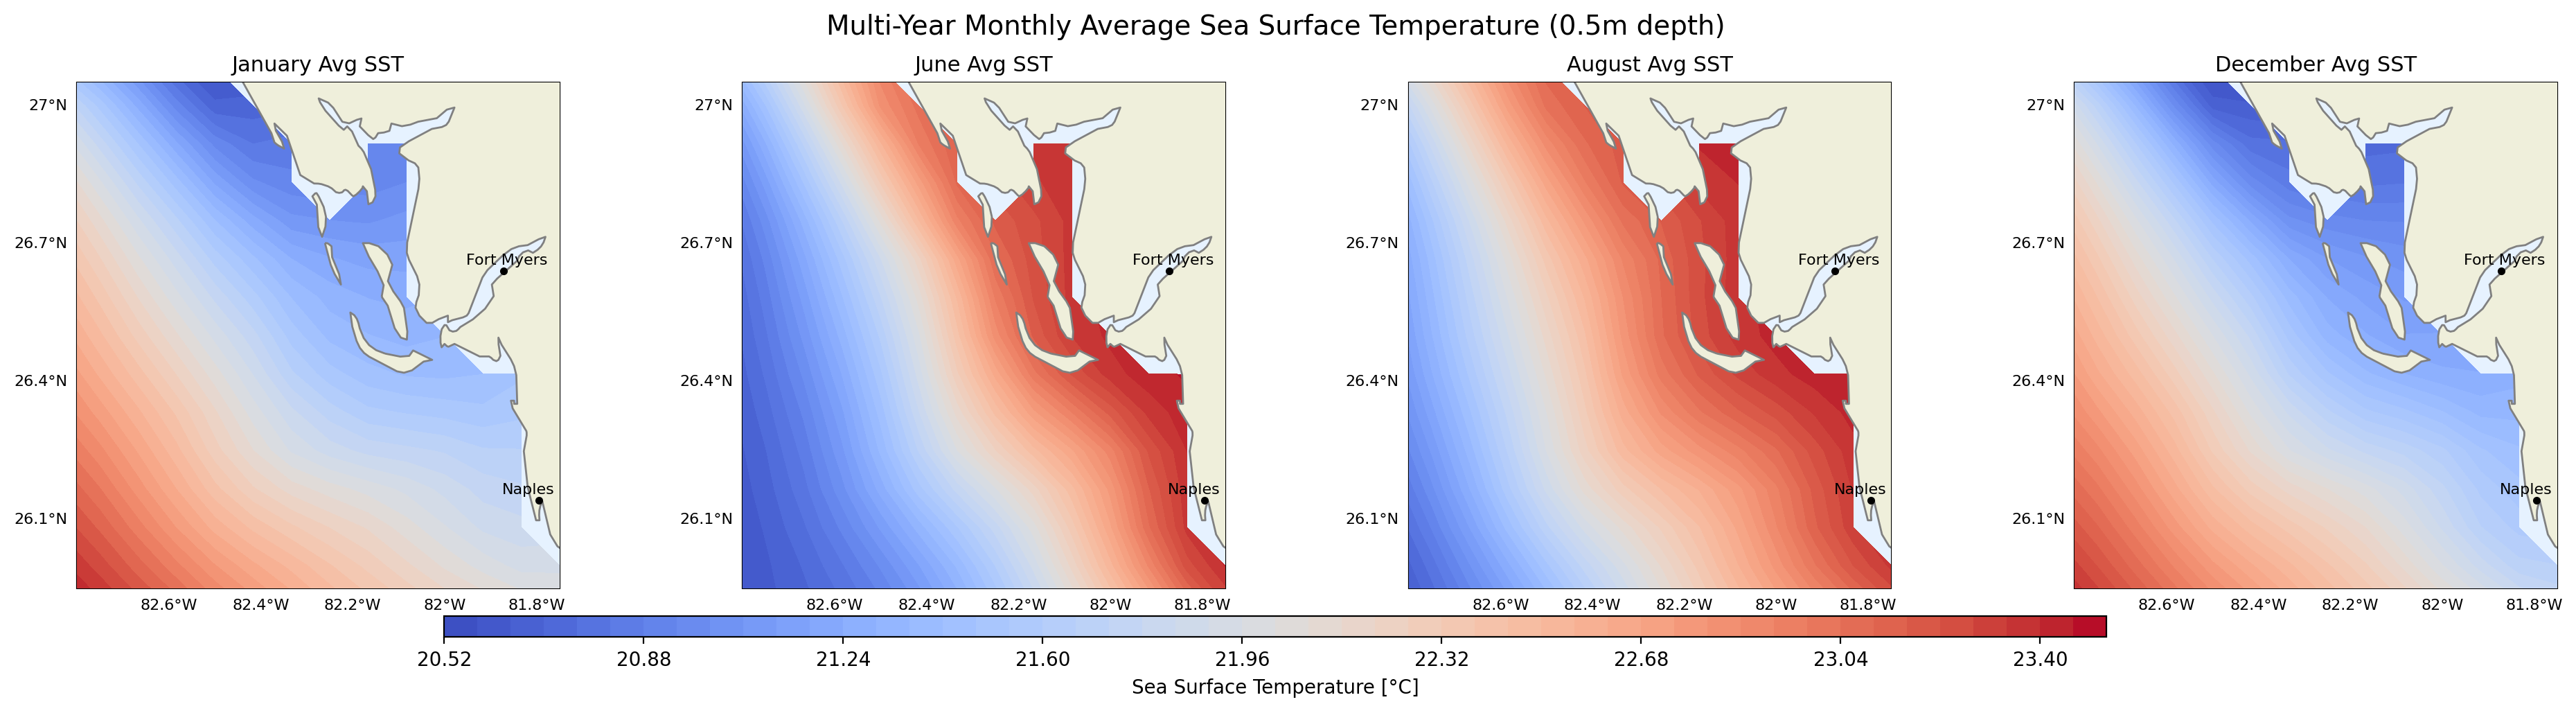

In [121]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load SST NetCDF files
file_list = [
    "C:/Users/mkduu/Downloads/cmems_mod_glo_phy_my_0.083deg_P1D-m_thetao_82.83W-81.75W_25.92N-27.08N_0.49-9.57m_1993-01-01-2021-06-30.nc",
    "C:/Users/mkduu/Downloads/cmems_mod_glo_phy_myint_0.083deg_P1D-m_thetao_82.83W-81.75W_25.92N-27.08N_0.49-9.57m_2021-07-01-2025-02-25.nc"
]

ds_combined = xr.open_mfdataset(file_list, combine='by_coords')

sst_surface = ds_combined.thetao.sel(depth=0.5, method='nearest')
monthly_avg_sst = sst_surface.groupby('time.month').mean(dim='time')

# === Seasonal months and labels ===
seasonal_months = [1, 6, 8, 12]
month_names = ['January', 'June', 'August', 'December']

# === Create figure and axes ===
fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200)

# === Store last contour for shared colorbar ===
last_plot = None

for ax, month, label in zip(axes, seasonal_months, month_names):
    sst_data = monthly_avg_sst.sel(month=month)

    ax.set_extent([-82.8, -81.75, 25.95, 27.05], crs=ccrs.PlateCarree())
    ax.set_facecolor(cfeature.COLORS['water'])

    # === Bathymetry ===
    bathymetry_names = ['bathymetry_L_0', 'bathymetry_K_200',
                        'bathymetry_J_1000', 'bathymetry_I_2000',
                        'bathymetry_H_3000', 'bathymetry_G_4000']
    colors = [(0.9, 0.95, 1), (0.7, 0.85, 1), (0.5, 0.75, 1),
              (0.3, 0.65, 1), (0.1, 0.55, 1), (0, 0.45, 1)]
    for name, color in zip(bathymetry_names, colors):
        ax.add_feature(cfeature.NaturalEarthFeature(
            'physical', name, '10m', edgecolor='none', facecolor=color), zorder=5)

    # === Rivers ===
    ax.add_feature(cfeature.NaturalEarthFeature(
        'physical', 'rivers_lake_centerlines', scale='10m',
        edgecolor='blue', facecolor='none'), zorder=6)
    ax.add_feature(cfeature.NaturalEarthFeature(
        'physical', 'rivers_north_america', scale='10m',
        edgecolor='blue', facecolor='none', alpha=0.5), zorder=6)

    # === SST Contour Plot ===
    last_plot = ax.contourf(
        ds_combined.longitude,
        ds_combined.latitude,
        sst_data.squeeze(),
        transform=ccrs.PlateCarree(),
        levels=50,
        cmap='coolwarm',
        zorder=10
    )

    # === Land & Borders ===
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=20)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=21)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=21)
    ax.add_feature(cfeature.BORDERS, edgecolor='red', facecolor='none', linewidth=2, zorder=22)

    # === City markers ===
    for city, (lat, lon) in {
        "Fort Myers": [26.6406, -81.8723],
        "Naples": [26.142, -81.7948]
    }.items():
        ax.plot(lon, lat, marker='o', color='black', markersize=3,
                transform=ccrs.PlateCarree(), zorder=23)
        ax.text(lon - 0.08, lat + 0.015, city, transform=ccrs.PlateCarree(),
                color='black', fontsize=8, zorder=23)

    # === Gridlines ===
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5,
                      linestyle='--', zorder=25)
    gl.xlocator = mticker.FixedLocator([-82.6, -82.4, -82.2, -82.0, -81.8])
    gl.ylocator = mticker.FixedLocator([26.1, 26.4, 26.7, 27.0])
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    ax.set_title(f'{label} Avg SST', fontsize=11)

# === Shared colorbar BELOW plots ===
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(last_plot, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Sea Surface Temperature [°C]')

# === Title & Layout ===
fig.suptitle('Multi-Year Monthly Average Sea Surface Temperature (0.5m depth)', fontsize=14)
plt.subplots_adjust(left=0.05, right=0.98, top=0.88, bottom=0.15, wspace=0.15)
plt.show()

## 6. Process and Visualize Wind Speed and Direction

This section processes daily wind data collected at Page Field Airport to extract wind speed (WSF5) and wind direction (WDF5), then converts those values into vector components (u/v) for spatial visualization. To avoid distortion from extreme weather events like tropical storms and hurricanes, all wind speeds ≥ 16 m/s are excluded from the dataset. The remaining data is used to identify the peak wind for each month (after filtering), which allows for seasonal analysis of typical wind flow across Southwest Florida.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

In [116]:
# === Load and process wind data ===
df_wind = pd.read_csv('C:/Users/mkduu/Downloads/3988701.csv')
df_wind['DATE'] = pd.to_datetime(df_wind['DATE'])
df_wind = df_wind.dropna(subset=['WDF5', 'WSF5'])

# Filter out tropical storm and hurricane winds (≥ 17 m/s)
df_wind = df_wind[df_wind['WSF5'] < 16]

# Convert FROM direction to TO direction
df_wind['u'] = -df_wind['WSF5'] * np.sin(np.radians(df_wind['WDF5']))
df_wind['v'] = -df_wind['WSF5'] * np.cos(np.radians(df_wind['WDF5']))
df_wind['Month'] = df_wind['DATE'].dt.month 

# === Monthly peak wind vector (row with max WSF5 after filter) ===
monthly_peak = df_wind.loc[df_wind.groupby('Month')['WSF5'].idxmax()].set_index('Month')

### 6.1 Seasonal Peak Wind Vectors Over Southwest Florida

This section visualizes seasonal peak wind vectors across Southwest Florida using filtered wind data from Page Field Airport. After removing extreme outliers (wind speeds ≥ 16 m/s), the script calculates the highest remaining daily wind speed for each month, then averages those peaks across all available years for January, June, August, and December. The resulting u/v vector components are applied to a uniform geographic grid to display seasonal wind flow direction and relative intensity. The map provides insight into typical peak wind behavior throughout the year while avoiding distortion from tropical storms or hurricanes.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\181617285.py:63: UserWarning: This figure includes Axes that are n

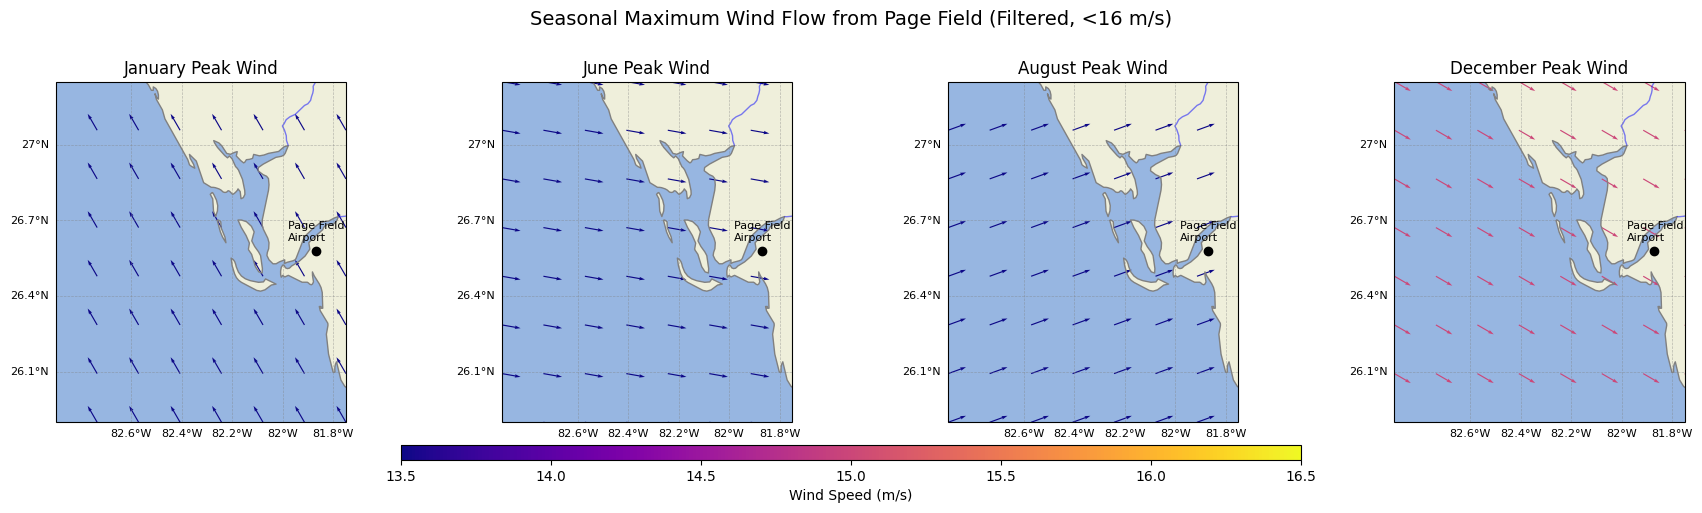

In [122]:
# === Set up grid ===
lon_vals = np.linspace(-82.9, -81.75, 8)
lat_vals = np.linspace(25.9, 27.25, 8)
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# === Plot ===
fig, axes = plt.subplots(1, 4, figsize=(18, 5), subplot_kw={'projection': ccrs.PlateCarree()})
months = [1, 6, 8, 12]
labels = ['January', 'June', 'August', 'December']
station_lon, station_lat = -81.87, 26.58

for i, (month, label) in enumerate(zip(months, labels)):
    ax = axes[i]
    ax.set_extent([-82.9, -81.75, 25.9, 27.25])
    ax.set_facecolor(cfeature.COLORS['water'])

    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray')
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                edgecolor='blue', facecolor='none'))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                edgecolor='blue', facecolor='none', alpha=0.5))

    # Peak wind vector
    u = monthly_peak.loc[month, 'u']
    v = monthly_peak.loc[month, 'v']
    magnitude = np.sqrt(u**2 + v**2)

    u_grid = np.full_like(lon2d, u)
    v_grid = np.full_like(lat2d, v)
    mag_grid = np.full_like(lon2d, magnitude)

    quiv = ax.quiver(
        lon2d, lat2d, u_grid, v_grid, mag_grid,
        transform=ccrs.PlateCarree(),
        cmap='plasma',
        scale=200,
        scale_units='xy',
        width=0.004
    )

    ax.plot(station_lon, station_lat, marker='o', color='black', transform=ccrs.PlateCarree())
    ax.text(station_lon - 0.11, station_lat + 0.04, 'Page Field\nAirport',
            fontsize=8, transform=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator([-82.6, -82.4, -82.2, -82.0, -81.8])
    gl.ylocator = mticker.FixedLocator([26.1, 26.4, 26.7, 27.0])

    ax.set_title(f'{label} Peak Wind')

# Colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])
fig.colorbar(quiv, cax=cbar_ax, orientation='horizontal', label='Wind Speed (m/s)')

fig.suptitle('Seasonal Maximum Wind Flow from Page Field (Filtered, <16 m/s)', fontsize=14)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.show()

## 7. Visualize Karenia brevis (Red Tide) Blooms in Southwest Florida

This section utilizes data from the Harmful Algal BloomS Observing System (HABSOS), managed by NOAA's National Centers for Environmental Information (NCEI), to visualize Karenia brevis concentrations along the Southwest Florida coast near Fort Myers and Naples. The data is processed to filter sampling dates and locations, and concentrations are represented using color-coded markers based on severity levels: red dots indicate the highest concentrations (>1,000,000 cells/L), orange denotes moderate levels, and yellow represents lower but still significant presence. City labels and gridlines provide geographic context, aiding in identifying bloom intensity and distribution across the region.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


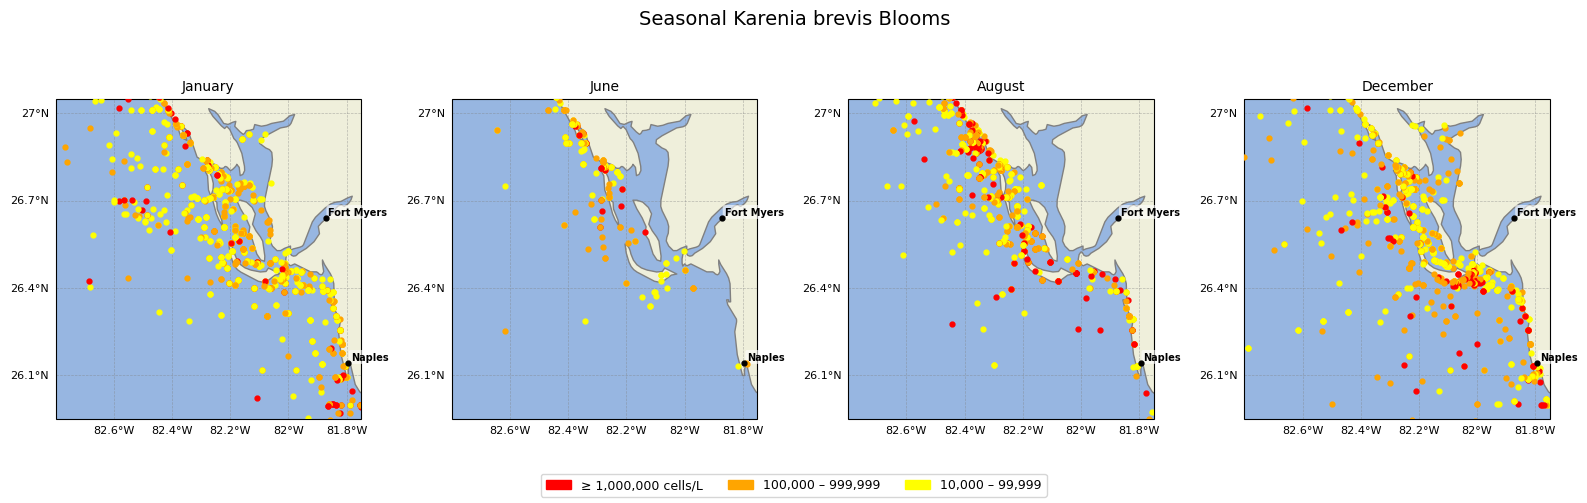

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

# === Load and filter HAB dataset ===
hab_df = pd.read_csv('C:/Users/mkduu/Downloads/habsos_20240430.csv', low_memory=False)
hab_df = hab_df[['STATE_ID', 'DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'SAMPLE_DATE', 'CELLCOUNT']]
hab_df['SAMPLE_DATE'] = pd.to_datetime(hab_df['SAMPLE_DATE'], errors='coerce')
hab_df['CELLCOUNT'] = pd.to_numeric(hab_df['CELLCOUNT'], errors='coerce')
hab_df = hab_df.dropna(subset=['SAMPLE_DATE', 'CELLCOUNT'])
hab_df = hab_df[hab_df['CELLCOUNT'] > 0]

# === Filter by region and extract month ===
df = hab_df[
    (hab_df['LATITUDE'] >= 25.9) & (hab_df['LATITUDE'] <= 27.25) &
    (hab_df['LONGITUDE'] >= -82.9) & (hab_df['LONGITUDE'] <= -81.75)
].copy()
df['Month'] = df['SAMPLE_DATE'].dt.month

# === Setup ===
target_months = [1, 6, 8, 12]
month_labels = ['January', 'June', 'August', 'December']
extent = [-82.8, -81.75, 25.95, 27.05]
city_locations = {
    "Fort Myers": (26.6406, -81.8723),
    "Naples": (26.1420, -81.7948),
}

fig, axes = plt.subplots(1, 4, figsize=(16, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, (month, label) in enumerate(zip(target_months, month_labels)):
    ax = axes[i]
    ax.set_extent(extent)
    
    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue')

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator([-82.6, -82.4, -82.2, -82.0, -81.8])
    gl.ylocator = mticker.FixedLocator([26.1, 26.4, 26.7, 27.0])

    df_month = df[df['Month'] == month]
    for _, row in df_month.iterrows():
        lat, lon, count = row['LATITUDE'], row['LONGITUDE'], row['CELLCOUNT']
        if count >= 1e6:
            color = 'red'
        elif count >= 1e5:
            color = 'orange'
        elif count >= 1e4:
            color = 'yellow'
        else:
            continue
        ax.plot(lon, lat, marker='o', color=color, markersize=3.5, transform=ccrs.PlateCarree(), zorder=5)

    # City labels
    for city, (lat, lon) in city_locations.items():
        ax.plot(lon, lat, marker='o', color='black', markersize=3.5, transform=ccrs.PlateCarree(), zorder=6)
        ax.text(lon + 0.01, lat + 0.01, city, transform=ccrs.PlateCarree(), fontsize=7, weight='bold',
                color='black', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_title(label, fontsize=10)

# === Legend ===
legend_handles = [
    mpatches.Patch(color='red', label='≥ 1,000,000 cells/L'),
    mpatches.Patch(color='orange', label='100,000 – 999,999'),
    mpatches.Patch(color='yellow', label='10,000 – 99,999')
]
fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=9)

fig.suptitle("Seasonal Karenia brevis Blooms", fontsize=14)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

## 8. Visualize Seasonal Maximum Discharge at Caloosahatchee River (S.R. 79)

This section processes streamflow data from USGS Site 2292900 (Caloosahatchee River at S.R. 79 near Olga) to calculate and visualize seasonal discharge trends. For each year in the dataset, the maximum daily discharge for the months of January, June, August, and December is identified. These seasonal peaks are then averaged across all available years to produce a representative value for each month. The results are displayed as a 4-panel map, using both circle size and color to reflect the strength of seasonal peak discharge.

### 8.1 Prepare Discharge Data for Seasonal Flow Visualization

This section loads daily streamflow data from the USGS monitoring site at Caloosahatchee River (S.R. 79 near Olga) and prepares it for seasonal analysis. After parsing the dataset and extracting the relevant time components (month and year), the code identifies the maximum daily discharge for each target month (January, June, August, December) in each year. It then calculates the multi-year average of these monthly maxima to represent seasonal discharge behavior over time. The resulting values will be used to visualize spatial trends in river flow intensity across the year.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

# === Load and clean discharge data ===
df_dis = pd.read_csv('C:/Users/mkduu/Downloads/USGS Data Science Project.csv')
df_dis['Date'] = pd.to_datetime(df_dis['Date'], errors='coerce')
df_dis = df_dis.dropna(subset=['Date', 'Discharge'])
df_dis['Month'] = df_dis['Date'].dt.month
df_dis['Year'] = df_dis['Date'].dt.year

# === Compute max monthly discharge for each year, then average across years ===
target_months = [1, 6, 8, 12]
month_labels = ['January', 'June', 'August', 'December']

seasonal_max = (
    df_dis[df_dis['Month'].isin(target_months)]
    .groupby(['Year', 'Month'])['Discharge']
    .max()
    .reset_index()
)

monthly_avg_discharge = (
    seasonal_max.groupby('Month')['Discharge']
    .mean()
    .reindex(target_months)
)

### 8.2 Visualize Seasonal Max Discharge at Caloosahatchee River (S.R. 79)

This section creates a seasonal map showing the maximum monthly discharge, averaged across multiple years. Using four subplots (January, June, August, December), each map displays a single circle marker over the discharge site, where marker size and color both reflect the intensity of average seasonal peak discharge in cubic feet per second (cfs). A shared horizontal colorbar provides a visual scale for interpreting discharge magnitudes across the seasons.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\93431619.py:51: UserWarning: This figure includes Axes that are no

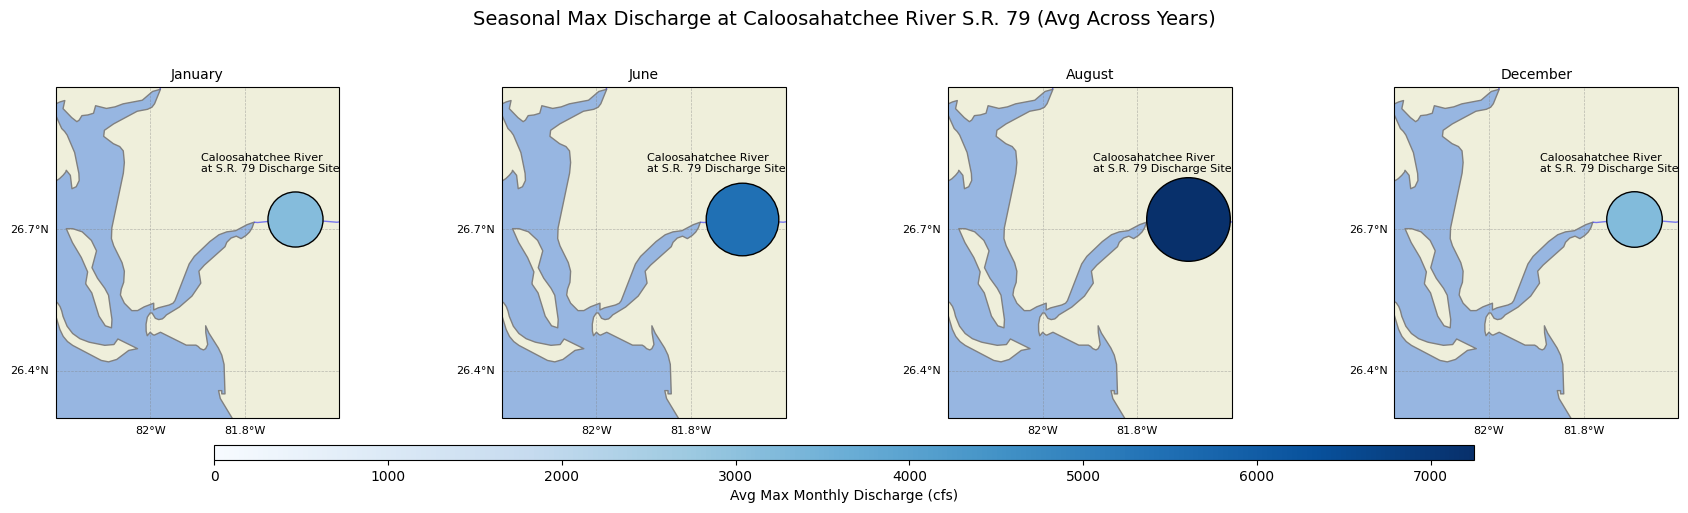

In [126]:
# === Plot Setup ===
station_lon, station_lat = -81.693, 26.721
extent = [-82.2, -81.6, 26.3, 27.0]
cmap = cm.Blues
vmax = monthly_avg_discharge.max()
norm = mcolors.Normalize(vmin=0, vmax=vmax)

fig, axes = plt.subplots(1, 4, figsize=(18, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, (month, label) in enumerate(zip(target_months, month_labels)):
    ax = axes[i]
    ax.set_extent(extent)
    ax.set_facecolor(cfeature.COLORS['water'])

    # Add basemap features
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='gray', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                edgecolor='blue', facecolor='none'), zorder=2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                edgecolor='blue', facecolor='none', alpha=0.5), zorder=2)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator([-82.6, -82.4, -82.2, -82.0, -81.8])
    gl.ylocator = mticker.FixedLocator([26.1, 26.4, 26.7, 27.0])

    # Discharge circle
    discharge_val = monthly_avg_discharge.loc[month]
    ax.scatter(station_lon, station_lat,
               s=discharge_val * 0.5,
               c=[[discharge_val]], cmap=cmap, norm=norm,
               edgecolor='black', zorder=3)

    ax.text(station_lon - 0.2, station_lat + 0.1, 'Caloosahatchee River\nat S.R. 79 Discharge Site',
            fontsize=8, transform=ccrs.PlateCarree(), zorder=4)

    ax.set_title(label, fontsize=10)

# === Add shared colorbar ===
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal', label='Avg Max Monthly Discharge (cfs)')

fig.suptitle('Seasonal Max Discharge at Caloosahatchee River S.R. 79 (Avg Across Years)', fontsize=14)
plt.tight_layout(rect=[0, 0.13, 1, 0.93])
plt.show()

## 9. Extract and Prepare Nutrient Monitoring Data for Caloosahatchee River Sites

In [143]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Load nutrient data files ===
df_upper = pd.read_csv('C:/Users/mkduu/Downloads/TN_TP_Caloosa.csv')
df_tidal = pd.read_csv('C:/Users/mkduu/Downloads/TN_TP_Tidal_Caloosa.csv')

# === Define target station names ===
target_stations = [
    "CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA",  # upper
    "DEEP LAGOON- McGregor Blvd",                 # tidal
    "Caloosahatchee River, northwest of Caloosahatchee Bridge"  # tidal
]

# === Filter for those stations ===
df_upper_filtered = df_upper[df_upper['StationName'].isin(target_stations[:1])]
df_tidal_filtered = df_tidal[df_tidal['StationName'].isin(target_stations[1:])]

# === Combine filtered data ===
df_all = pd.concat([df_upper_filtered, df_tidal_filtered], ignore_index=True)

# === Preview ===
df_all[['StationName', 'Actual_Latitude', 'Actual_Longitude']].drop_duplicates()

,StationName,Actual_Latitude,Actual_Longitude


In [145]:
print(df_all[['Actual_Latitude', 'Actual_Longitude']].dtypes)
print("\nMissing values:")
print(df_all[['Actual_Latitude', 'Actual_Longitude']].isna().sum())

Actual_Latitude     float64
Actual_Longitude    float64
dtype: object

Missing values:
Actual_Latitude     0
Actual_Longitude    0
dtype: int64


### 9.1 Plot Monitoring Station Locations Along the Caloosahatchee River

This section generates a foundational map showing the geographic locations of three key nutrient monitoring sites along the Caloosahatchee River: S.R. 79 near Olga (upper river), McGregor Blvd, and the site near the Caloosahatchee Bridge (both tidal). It uses Cartopy to build a coastal base map and plots each station with labeled markers for reference, providing spatial context for interpreting TN and TP data in later visualizations.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


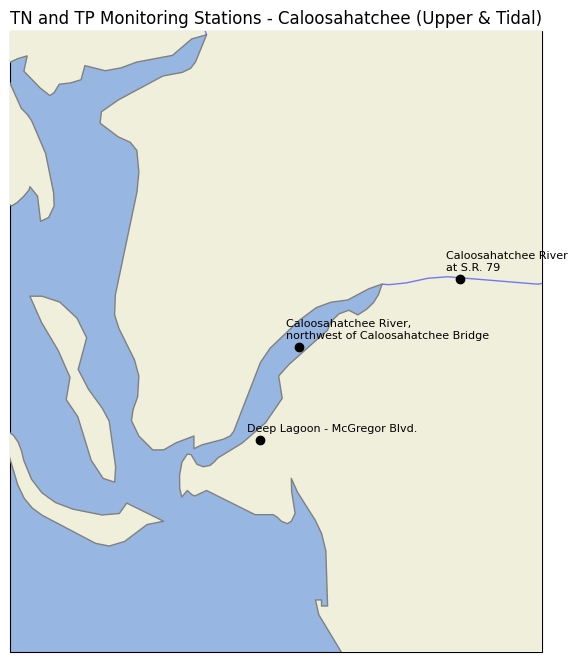

In [129]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Coordinates for Upper and Tidal Stations ===
station_coords = {
    "Caloosahatchee River\nat S.R. 79": (26.721, -81.693),
    "Deep Lagoon - McGregor Blvd.": (26.539, -81.918),
    "Caloosahatchee River,\nnorthwest of Caloosahatchee Bridge": (26.644, -81.874)
}

# === Setup Map ===
fig = plt.figure(figsize=(6, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-82.2, -81.6, 26.3, 27.0], crs=ccrs.PlateCarree())

# === Enhanced Base map layers ===
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=20)
ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=21)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=21)
ax.add_feature(cfeature.BORDERS, edgecolor='red', facecolor='none', linewidth=2, zorder=22)
ax.add_feature(cfeature.NaturalEarthFeature(
    'physical', 'rivers_lake_centerlines', scale='10m',
    edgecolor='blue', facecolor='none'), zorder=21)
ax.add_feature(cfeature.NaturalEarthFeature(
    'physical', 'rivers_north_america', scale='10m',
    edgecolor='blue', facecolor='none', alpha=0.5), zorder=21)

# === Plot station locations ===
for name, (lat, lon) in station_coords.items():
    ax.plot(lon, lat, marker='o', color='black', markersize=6, transform=ccrs.PlateCarree(), zorder=25)
    ax.text(lon - 0.015, lat +.01, name, fontsize=8, transform=ccrs.PlateCarree(), zorder=25)

# === Final formatting ===
ax.set_title("TN and TP Monitoring Stations - Caloosahatchee (Upper & Tidal)", fontsize=12)
plt.tight_layout()
plt.show()

In [158]:
print(df_upper.columns.tolist())
print(df_tidal.columns.tolist())

['WBodyID', 'WaterBodyName', 'DataSource', 'StationID', 'StationName', 'Actual_StationID', 'Actual_Latitude', 'Actual_Longitude', 'DEP_WBID', 'SampleDate', 'ActivityDepth', 'DepthUnits', 'Parameter', 'Characteristic', 'Sample_Fraction', 'Result_Value', 'Result_Unit', 'QACode', 'Result_Comment', 'Original_Result_Value', 'Original_Result_Unit']
['WBodyID', 'WaterBodyName', 'DataSource', 'StationID', 'StationName', 'Actual_StationID', 'Actual_Latitude', 'Actual_Longitude', 'DEP_WBID', 'SampleDate', 'ActivityDepth', 'DepthUnits', 'Parameter', 'Characteristic', 'Sample_Fraction', 'Result_Value', 'Result_Unit', 'QACode', 'Result_Comment', 'Original_Result_Value', 'Original_Result_Unit']


### 9.2 Seasonal Nutrient Trends at Upper Caloosahatchee (S.R. 79 near Olga)

This section visualizes monthly Total Nitrogen (TN) and Total Phosphorus (TP) concentrations at the S.R. 79 monitoring station near Olga, located in the upper Caloosahatchee River. It filters, cleans, and prepares the data, then generates one subplot for each selected month (January, June, August, December). Each subplot shows TN and TP levels with colored circles, using a consistent color scale to enable visual comparison across months. Horizontal colorbars help interpret concentration values, and the layout ensures clear geographic reference throughout the year.  

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\3382658506.py:88: UserWarning: This figure includes Axes that are 

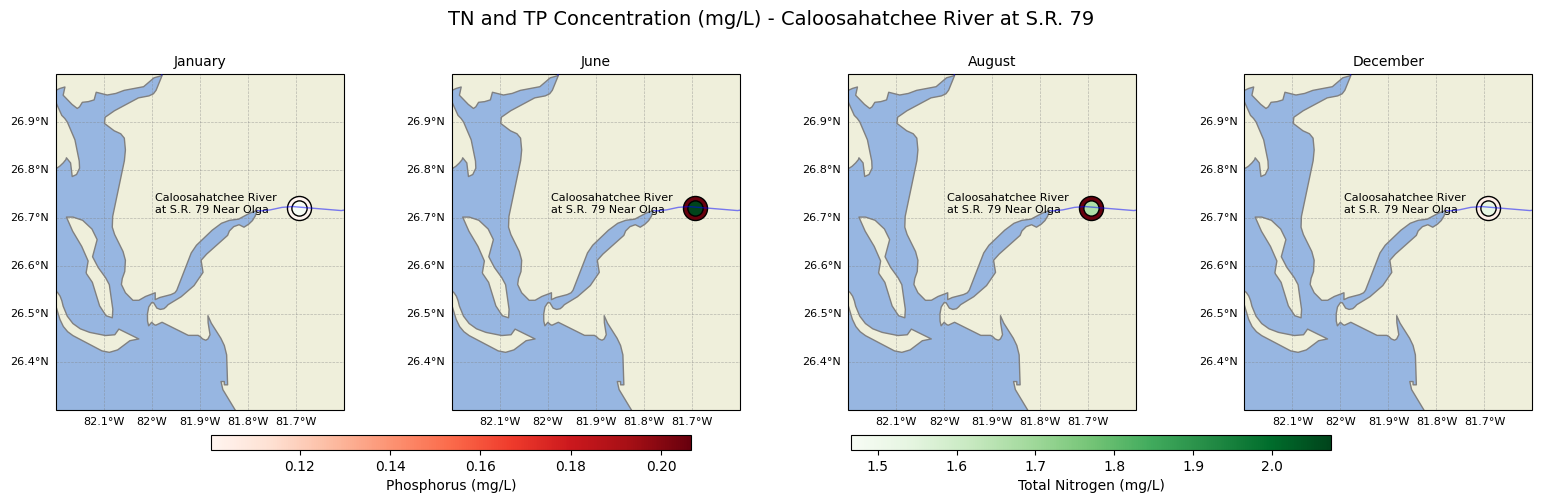

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Combine loaded datasets ===
#df = pd.concat([df_upper, df_tidal], ignore_index=True)

# === Clean and parse ===
df_upper['SampleDate'] = pd.to_datetime(df_upper['SampleDate'], errors='coerce')
df_upper['Month'] = df_upper['SampleDate'].dt.month

# === Station info ===
station_name = "CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA"
station_lat, station_lon = 26.7211, -81.6932
target_months = [1, 6, 8, 12]
month_labels = ['January', 'June', 'August', 'December']

# === Filter data for the station ===
df_upper_station = df_upper[df_upper['StationName'].str.strip().str.lower() == station_name.lower()]
df_upper_tp = df_upper_station[df_upper_station['Characteristic'].str.contains('Phosphorus as P', case=False, na=False)]
df_upper_tn = df_upper_station[df_upper_station['Characteristic'].str.contains('Nitrogen', case=False, na=False)]

# === Compute monthly means ===
mean_upper_tp = df_upper_tp.groupby('Month')['Result_Value'].mean().reindex(target_months)
mean_upper_tn = df_upper_tn.groupby('Month')['Result_Value'].mean().reindex(target_months)

# === Normalize color mapping ===
norm_upper_tp = mcolors.Normalize(vmin=mean_upper_tp.min(), vmax=mean_upper_tp.max())
norm_upper_tn = mcolors.Normalize(vmin=mean_upper_tn.min(), vmax=mean_upper_tn.max())
cmap_upper_tp = cm.Reds
cmap_upper_tn = cm.Greens

# === Plot setup ===
fig, axes = plt.subplots(1, 4, figsize=(16, 5), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [-82.2, -81.6, 26.3, 27.0]

for i, (month, label) in enumerate(zip(target_months, month_labels)):
    ax = axes[i]
    ax.set_extent(extent)
    
    # Enhanced base layers
    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='gray', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                edgecolor='blue', facecolor='none'), zorder=2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                edgecolor='blue', facecolor='none', alpha=0.5), zorder=21)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Dot colors
    tp_upper_val = mean_upper_tp.get(month, None)
    tn_upper_val = mean_upper_tn.get(month, None)
    
    if pd.notnull(tp_upper_val):
        ax.scatter(station_lon, station_lat, s=300, c=[[tp_upper_val]], cmap=cmap_upper_tp, norm=norm_upper_tp, edgecolor='black', zorder=3)
    if pd.notnull(tn_val):
        ax.scatter(station_lon, station_lat, s=120, c=[[tn_upper_val]], cmap=cmap_upper_tn, norm=norm_upper_tn, edgecolor='black', zorder=4)
  
    # Label
    ax.text(station_lon -.3, station_lat - 0.01, "Caloosahatchee River\nat S.R. 79 Near Olga",
            fontsize=8, color='black', zorder=5)

    ax.set_title(label, fontsize=10)

# === Add horizontal colorbars below the plots ===
cbar_ax_upper_tp = fig.add_axes([0.15, 0.10, 0.3, 0.03])  # y-position was 0.13, now lowered to 0.10
cbar_ax_upper_tn = fig.add_axes([0.55, 0.10, 0.3, 0.03])  # same here

sm_upper_tp = cm.ScalarMappable(norm=norm_upper_tp, cmap=cmap_upper_tp)
sm_upper_tn = cm.ScalarMappable(norm=norm_upper_tn, cmap=cmap_upper_tn)

fig.colorbar(sm_upper_tp, cax=cbar_ax_upper_tp, orientation='horizontal', label='Phosphorus (mg/L)')
fig.colorbar(sm_upper_tn, cax=cbar_ax_upper_tn, orientation='horizontal', label='Total Nitrogen (mg/L)')

# === Title & Layout ===
fig.suptitle("TN and TP Concentration (mg/L) - Caloosahatchee River at S.R. 79", fontsize=14)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()

### 9.3 Seasonal Nutrient Trends at Caloosahatchee River, Northwest of Caloosahatchee Bridge

This section analyzes seasonal TN and TP concentrations at the monitoring station located northwest of the Caloosahatchee Bridge. It filters the dataset for valid samples, accounts for slight variations in station naming, and plots monthly concentrations for January, June, August, and December. The figure uses color-coded circles and uniform color scales across subplots to allow direct visual comparison of nutrient levels throughout the year.

C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\2188287218.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cb_tp['Result_Value'] = pd.to_numeric(df_cb_tp['Result_Value'], errors='coerce')
C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\2188287218.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cb_tn['Result_Value'] = pd.to_numeric(df_cb_tn['Result_Value'], errors='coerce')
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no e

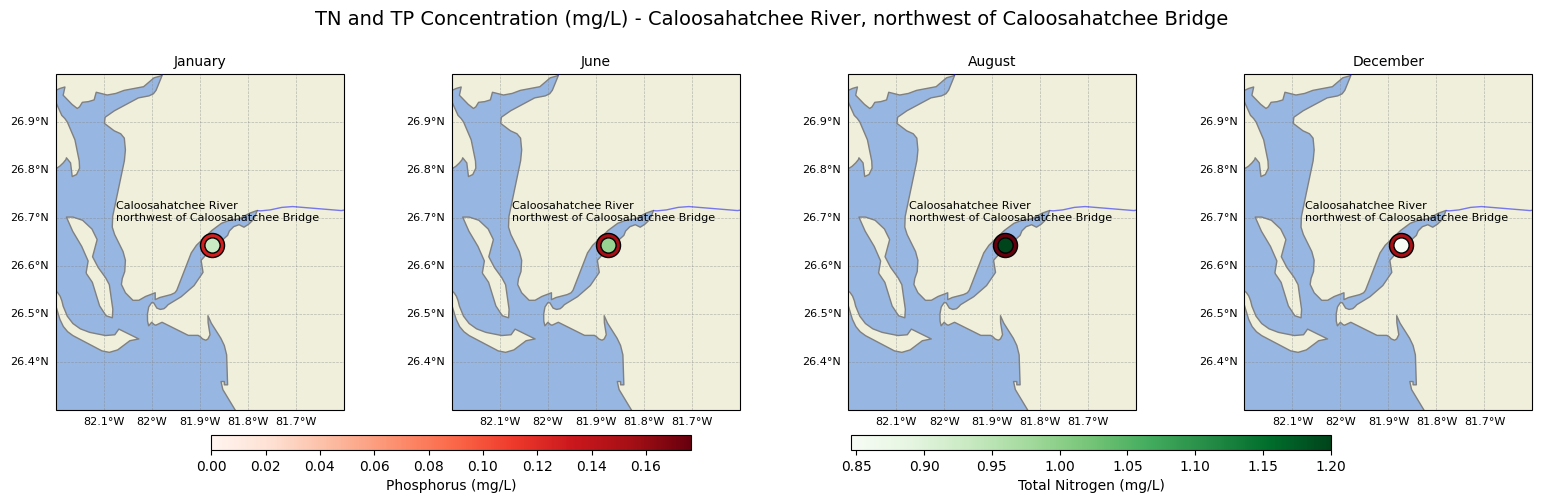

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Clean and parse tidal dataset ===
df_tidal['SampleDate'] = pd.to_datetime(df_tidal['SampleDate'], errors='coerce')
df_tidal['Month'] = df_tidal['SampleDate'].dt.month

# === Station info for Caloosahatchee Bridge site ===
valid_cb_names = [
    "Caloosahatchee River, northwest of Caloosahatchee Bridge",
    "Caloosahatchee River, northwest of Caloosahatchee Bridge and McGregor Boulevard intersection."
]
station_lat_cb, station_lon_cb = 26.6439, -81.8742
target_months = [1, 6, 8, 12]
month_labels = ['January', 'June', 'August', 'December']

# === Filter data for both station name variants ===
df_cb_station = df_tidal[df_tidal['StationName'].str.strip().isin(valid_cb_names)]
df_cb_tp = df_cb_station[df_cb_station['Characteristic'].str.contains('Phosphorus as P', case=False, na=False)]
df_cb_tn = df_cb_station[df_cb_station['Characteristic'].str.contains('Nitrogen', case=False, na=False)]

# === Clean numeric values ===
df_cb_tp['Result_Value'] = pd.to_numeric(df_cb_tp['Result_Value'], errors='coerce')
df_cb_tn['Result_Value'] = pd.to_numeric(df_cb_tn['Result_Value'], errors='coerce')

# === Compute monthly means ===
mean_cb_tp = df_cb_tp.groupby('Month')['Result_Value'].mean().reindex(target_months)
mean_cb_tn = df_cb_tn.groupby('Month')['Result_Value'].mean().reindex(target_months)

# --- Normalize color mapping ---
vmax_cb_tp = mean_cb_tp.max()
if pd.isna(vmax_cb_tp) or vmax_cb_tp == 0:
    vmax_cb_tp = 0.1  # fallback so the colormap still renders

norm_cb_tp = mcolors.Normalize(vmin=0, vmax=vmax_cb_tp)
norm_cb_tn = mcolors.Normalize(vmin=mean_cb_tn.min(), vmax=mean_cb_tn.max())
cmap_cb_tp = cm.Reds
cmap_cb_tn = cm.Greens

# === Plot setup ===
fig, axes = plt.subplots(1, 4, figsize=(16, 5), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [-82.2, -81.6, 26.3, 27.0]

for i, (month, label) in enumerate(zip(target_months, month_labels)):
    ax = axes[i]
    ax.set_extent(extent)

    # Enhanced base layers
    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='gray', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                edgecolor='blue', facecolor='none'), zorder=2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                edgecolor='blue', facecolor='none', alpha=0.5), zorder=21)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Dot colors
    tp_cb_val = mean_cb_tp.get(month, None)
    tn_cb_val = mean_cb_tn.get(month, None)

    if pd.notnull(tp_cb_val):
        ax.scatter(station_lon_cb, station_lat_cb, s=300, c=[[tp_cb_val]], cmap=cmap_cb_tp, norm=norm_cb_tp, edgecolor='black', zorder=3)
    if pd.notnull(tn_cb_val):
        ax.scatter(station_lon_cb, station_lat_cb, s=120, c=[[tn_cb_val]], cmap=cmap_cb_tn, norm=norm_cb_tn, edgecolor='black', zorder=4)

    # Label
    ax.text(station_lon_cb - 0.2, station_lat_cb + 0.05, "Caloosahatchee River\nnorthwest of Caloosahatchee Bridge",
            fontsize=8, color='black', zorder=5)

    ax.set_title(label, fontsize=10)

# === Add horizontal colorbars below the plots ===
cbar_ax_cb_tp = fig.add_axes([0.15, 0.10, 0.3, 0.03])
cbar_ax_cb_tn = fig.add_axes([0.55, 0.10, 0.3, 0.03])

sm_cb_tp = cm.ScalarMappable(norm=norm_cb_tp, cmap=cmap_cb_tp)
sm_cb_tn = cm.ScalarMappable(norm=norm_cb_tn, cmap=cmap_cb_tn)

fig.colorbar(sm_cb_tp, cax=cbar_ax_cb_tp, orientation='horizontal', label='Phosphorus (mg/L)')
fig.colorbar(sm_cb_tn, cax=cbar_ax_cb_tn, orientation='horizontal', label='Total Nitrogen (mg/L)')

# === Title & Layout ===
fig.suptitle("TN and TP Concentration (mg/L) - Caloosahatchee River, northwest of Caloosahatchee Bridge", fontsize=14)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()

### 9.4 Seasonal Nutrient Trends at Deep Lagoon (McGregor Blvd.)

This section maps seasonal TN and TP concentrations at the Deep Lagoon monitoring site near McGregor Blvd. After filtering and cleaning the dataset, it extracts values for four representative months—January, June, August, and December. The figure uses consistent color scales across subplots and stacked horizontal colorbars to enable direct comparison of nutrient levels over time. Marker size and shading help highlight shifts in nutrient concentrations throughout the year.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\2773402411.py:97: UserWarning: This figure includes Axes that are 

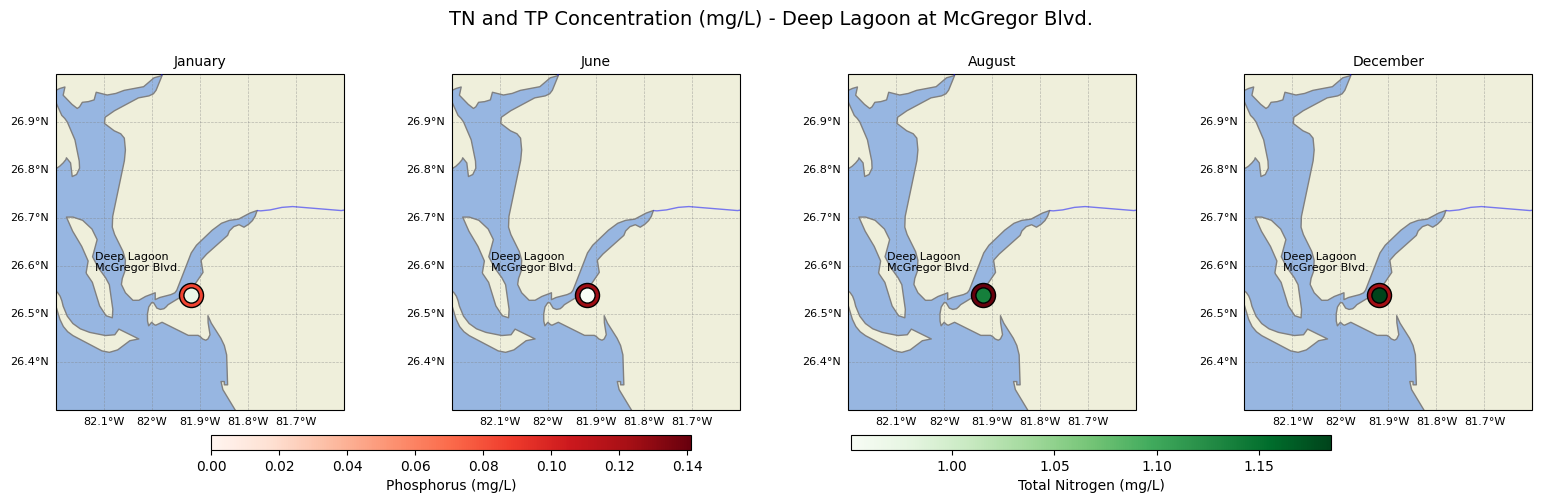

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Clean and parse tidal dataset ===
df_tidal['SampleDate'] = pd.to_datetime(df_tidal['SampleDate'], errors='coerce')
df_tidal['Month'] = df_tidal['SampleDate'].dt.month

# === Station info for Deep Lagoon ===
station_name_deep = "DEEP LAGOON- McGregor Blvd."
station_lat_deep, station_lon_deep = 26.5393, -81.9188
target_months = [1, 6, 8, 12]
month_labels = ['January', 'June', 'August', 'December']

# === Filter data for Deep Lagoon ===
df_deep_station = df_tidal[df_tidal['StationName'].str.strip() == station_name_deep]
df_deep_tp = df_deep_station[df_deep_station['Characteristic'].str.contains('Phosphorus as P', case=False, na=False)].copy()
df_deep_tn = df_deep_station[df_deep_station['Characteristic'].str.contains('Nitrogen', case=False, na=False)].copy()

# === Clean numeric values ===
df_deep_tp['Result_Value'] = pd.to_numeric(df_deep_tp['Result_Value'], errors='coerce')
df_deep_tn['Result_Value'] = pd.to_numeric(df_deep_tn['Result_Value'], errors='coerce')

# === Compute monthly means ===
mean_deep_tp = df_deep_tp.groupby('Month')['Result_Value'].mean().reindex(target_months)
mean_deep_tn = df_deep_tn.groupby('Month')['Result_Value'].mean().reindex(target_months)

# --- Normalize color mapping ---
vmax_deep_tp = mean_deep_tp.max()
if pd.isna(vmax_deep_tp) or vmax_deep_tp == 0:
    vmax_deep_tp = 0.1

vmax_deep_tn = mean_deep_tn.max()
if pd.isna(vmax_deep_tn) or vmax_deep_tn == 0:
    vmax_deep_tn = 1

norm_deep_tp = mcolors.Normalize(vmin=0, vmax=vmax_deep_tp)
norm_deep_tn = mcolors.Normalize(vmin=mean_deep_tn.min(), vmax=vmax_deep_tn)
cmap_deep_tp = cm.Reds
cmap_deep_tn = cm.Greens

# === Plot setup ===
fig, axes = plt.subplots(1, 4, figsize=(16, 5), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [-82.2, -81.6, 26.3, 27.0]

for i, (month, label) in enumerate(zip(target_months, month_labels)):
    ax = axes[i]
    ax.set_extent(extent)

    # Base layers
    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='gray', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                edgecolor='blue', facecolor='none'), zorder=2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                edgecolor='blue', facecolor='none', alpha=0.5), zorder=21)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Pull monthly mean values
    tp_val = mean_deep_tp.get(month, None)
    tn_val = mean_deep_tn.get(month, None)

    if pd.notnull(tp_val):
        ax.scatter(station_lon_deep, station_lat_deep, s=300, c=[[tp_val]], cmap=cmap_deep_tp, norm=norm_deep_tp, edgecolor='black', zorder=3)
    if pd.notnull(tn_val):
        ax.scatter(station_lon_deep, station_lat_deep, s=120, c=[[tn_val]], cmap=cmap_deep_tn, norm=norm_deep_tn, edgecolor='black', zorder=4)

    # Label
    ax.text(station_lon_deep - 0.2, station_lat_deep + 0.05, "Deep Lagoon\nMcGregor Blvd.",
            fontsize=8, color='black', zorder=5)

    ax.set_title(label, fontsize=10)

# === Colorbars ===
cbar_ax_deep_tp = fig.add_axes([0.15, 0.10, 0.3, 0.03])
cbar_ax_deep_tn = fig.add_axes([0.55, 0.10, 0.3, 0.03])

sm_deep_tp = cm.ScalarMappable(norm=norm_deep_tp, cmap=cmap_deep_tp)
sm_deep_tn = cm.ScalarMappable(norm=norm_deep_tn, cmap=cmap_deep_tn)

fig.colorbar(sm_deep_tp, cax=cbar_ax_deep_tp, orientation='horizontal', label='Phosphorus (mg/L)')
fig.colorbar(sm_deep_tn, cax=cbar_ax_deep_tn, orientation='horizontal', label='Total Nitrogen (mg/L)')

# === Title & Layout ===
fig.suptitle("TN and TP Concentration (mg/L) - Deep Lagoon at McGregor Blvd.", fontsize=14)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()

### 9.5 Stacked Comparison of Nutrient Concentrations Across Caloosahatchee River Sites With Normalized Scale

This section combines the monthly TN and TP data for all three Caloosahatchee River monitoring sites—S.R. 79 (upper), northwest of the Caloosahatchee Bridge (tidal), and Deep Lagoon at McGregor Blvd. (tidal)—into a single stacked map for visual comparison. Each row corresponds to a different location, and each column represents a month (January, June, August, December). Uniform color scales are used across all subplots to highlight spatial and seasonal nutrient trends.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no e

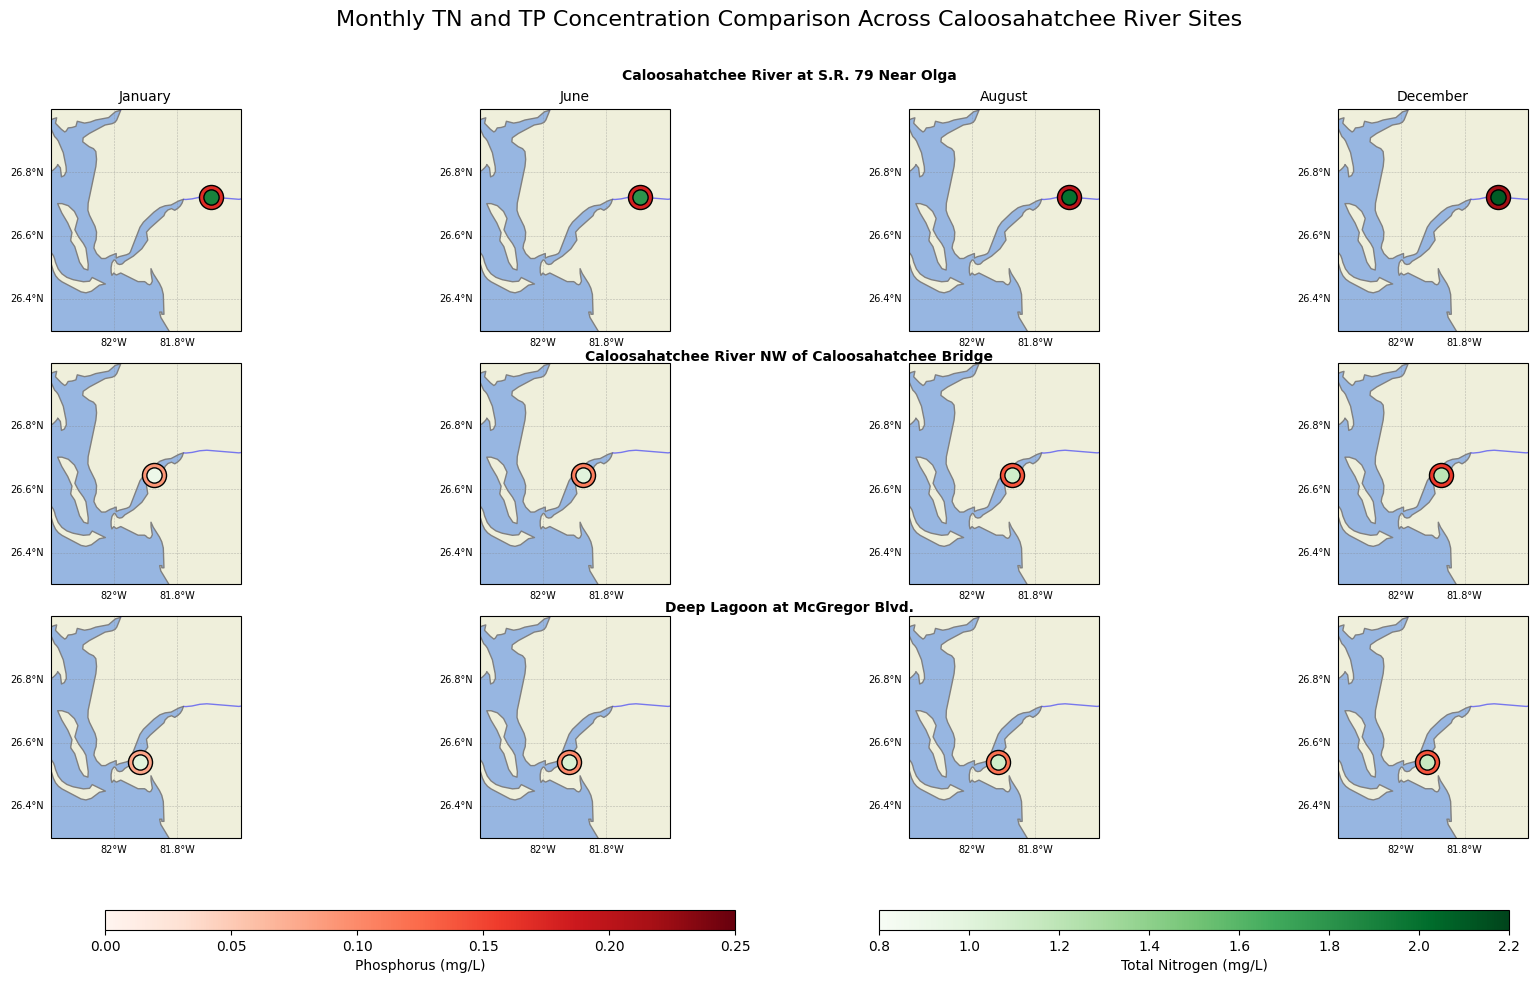

In [99]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Site coordinates ===
coords = {
    "SR79": (26.7211, -81.6932),
    "Bridge": (26.6439, -81.8742),
    "Deep": (26.5393, -81.9188)
}

# === Monthly means per site ===
target_months = [1, 6, 8, 12]
month_labels = ['January', 'June', 'August', 'December']

# === Replace with your actual calculated values if needed ===
mean_vals = {
    "SR79_TP": [0.17, 0.18, 0.20, 0.22],
    "SR79_TN": [1.9, 1.8, 2.0, 2.1],
    "Bridge_TP": [0.09, 0.11, 0.14, 0.16],
    "Bridge_TN": [0.9, 1.0, 1.1, 1.2],
    "Deep_TP": [0.08, 0.1, 0.12, 0.14],
    "Deep_TN": [1.0, 1.05, 1.1, 1.15]
}

titles = {
    "SR79": "Caloosahatchee River\nat S.R. 79 Near Olga",
    "Bridge": "Caloosahatchee River\nNW of Caloosahatchee Bridge",
    "Deep": "Deep Lagoon\nMcGregor Blvd."
}

# === Normalize color scale (same across all stations) ===
norm_tp = mcolors.Normalize(vmin=0, vmax=0.25)
norm_tn = mcolors.Normalize(vmin=0.8, vmax=2.2)
cmap_tp = cm.Reds
cmap_tn = cm.Greens

# === Plot ===
fig, axes = plt.subplots(3, 4, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [-82.2, -81.6, 26.3, 27.0]
stations = ["SR79", "Bridge", "Deep"]
row_titles = {
    "SR79": "Caloosahatchee River at S.R. 79 Near Olga",
    "Bridge": "Caloosahatchee River NW of Caloosahatchee Bridge",
    "Deep": "Deep Lagoon at McGregor Blvd."
}

for row_idx, site in enumerate(stations):
    lat, lon = coords[site]
    tp_means = mean_vals[f"{site}_TP"]
    tn_means = mean_vals[f"{site}_TN"]

    for col_idx, month in enumerate(target_months):
        ax = axes[row_idx, col_idx]
        ax.set_extent(extent)
        ax.set_facecolor(cfeature.COLORS['water'])
        ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=0)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='gray', linewidth=0.5, zorder=1)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                    edgecolor='blue', facecolor='none'), zorder=2)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                    edgecolor='blue', facecolor='none', alpha=0.5), zorder=2)
        
        gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator([-82.6, -82.4, -82.2, -82.0, -81.8])
        gl.ylocator = mticker.FixedLocator([26.4, 26.6, 26.8, 27.0])
        gl.top_labels = gl.right_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 7}
        gl.ylabel_style = {'size': 7}

        # Dot colors
        ax.scatter(lon, lat, s=300, c=[[tp_means[col_idx]]], cmap=cmap_tp, norm=norm_tp, edgecolor='black', zorder=3)
        ax.scatter(lon, lat, s=120, c=[[tn_means[col_idx]]], cmap=cmap_tn, norm=norm_tn, edgecolor='black', zorder=4)

        # Add column titles
        if row_idx == 0:
            ax.set_title(month_labels[col_idx], fontsize=10)

# === Correctly center site labels between each row ===
fig.text(0.5, 0.91, "Caloosahatchee River at S.R. 79 Near Olga", ha='center', fontsize=10, weight='bold')
fig.text(0.5, 0.629, "Caloosahatchee River NW of Caloosahatchee Bridge", ha='center', fontsize=10, weight='bold')
fig.text(0.5, 0.378, "Deep Lagoon at McGregor Blvd.", ha='center', fontsize=10, weight='bold')


# === Colorbars ===
cbar_ax_tp = fig.add_axes([0.12, 0.06, 0.35, 0.02])
cbar_ax_tn = fig.add_axes([0.55, 0.06, 0.35, 0.02])
fig.colorbar(cm.ScalarMappable(norm=norm_tp, cmap=cmap_tp), cax=cbar_ax_tp, orientation='horizontal', label='Phosphorus (mg/L)')
fig.colorbar(cm.ScalarMappable(norm=norm_tn, cmap=cmap_tn), cax=cbar_ax_tn, orientation='horizontal', label='Total Nitrogen (mg/L)')

# === Title & Layout ===
fig.suptitle("Monthly TN and TP Concentration Comparison Across Caloosahatchee River Sites", fontsize=16)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.show()

## 10. Visualize Seasonal Precipitation at Page Field Airport

This section calculates and visualizes the average monthly precipitation recorded at Page Field Airport for four representative months — January, June, August, and December — based on available multi-year data. Using cleaned precipitation records from a CSV file, the data is grouped by month and averaged across all years for each of the four selected months.

The results are displayed on a series of regional maps covering Southwest Florida. On each map, a circular marker is plotted at the Page Field location, with both size and color scaled to reflect the mean precipitation in inches for that month. The visualization uses consistent geographic formatting, gridlines, and basemap features to allow easy comparison between months and across other environmental datasets in the notebook.

C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\miniconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\mkduu\AppData\Local\Temp\ipykernel_20724\3134460872.py:63: UserWarning: This figure includes Axes that are 

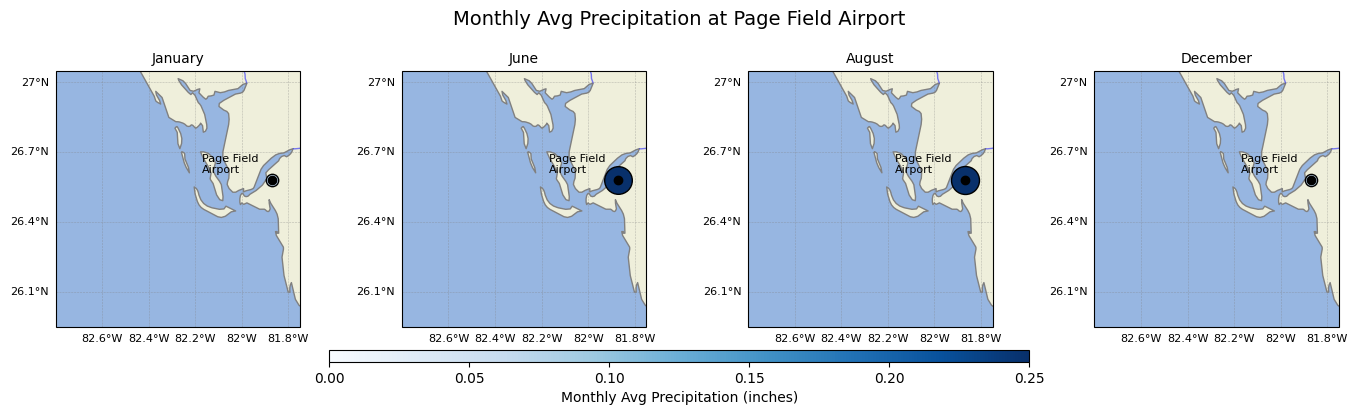

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import numpy as np

# === Load and clean data ===
df_prcp_pg = pd.read_csv('C:/Users/mkduu/Downloads/3988701.csv')  # Adjust path if needed
df_prcp_pg['DATE'] = pd.to_datetime(df_prcp_pg['DATE'], errors='coerce')
df_prcp_pg['PRCP'] = pd.to_numeric(df_prcp_pg['PRCP'], errors='coerce')

# === Calculate monthly means for selected months ===
target_months_pg = [1, 6, 8, 12]
month_labels_pg = ['January', 'June', 'August', 'December']
mean_prcp_pg = df_prcp_pg.groupby(df_prcp_pg['DATE'].dt.month)['PRCP'].mean().reindex(target_months_pg)

# === Map setup ===
fig, axes = plt.subplots(1, 4, figsize=(14, 4), subplot_kw={'projection': ccrs.PlateCarree()})
extent_pg = [-82.8, -81.75, 25.95, 27.05]
station_lon_pg, station_lat_pg = -81.87, 26.58
cmap_pg = plt.cm.Blues
norm_pg = mcolors.Normalize(vmin=0, vmax=0.25)

for i, (month, label) in enumerate(zip(target_months_pg, month_labels_pg)):
    ax = axes[i]
    ax.set_extent(extent_pg)
    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=1)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale='10m',
                                                edgecolor='blue', facecolor='none'), zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', scale='10m',
                                                edgecolor='blue', facecolor='none', alpha=0.5), zorder=1)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8,}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator([-82.6, -82.4, -82.2, -82.0, -81.8])
    gl.ylocator = mticker.FixedLocator([26.1, 26.4, 26.7, 27.0])

    # Dot and label
    prcp_val = mean_prcp_pg.get(month)
    if pd.notnull(prcp_val):
        ax.scatter(station_lon_pg, station_lat_pg, s=1200 * prcp_val, color=cmap_pg(norm_pg(prcp_val)), edgecolor='black', zorder=3)

    ax.plot(station_lon_pg, station_lat_pg, 'ko', zorder=4)
    ax.text(station_lon_pg - 0.3, station_lat_pg + 0.03, 'Page Field\nAirport', fontsize=8, zorder=5)
    ax.set_title(label, fontsize=10)

# === Colorbar ===
sm_pg = plt.cm.ScalarMappable(cmap=cmap_pg, norm=norm_pg)
cbar_ax_pg = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cbar = fig.colorbar(sm_pg, cax=cbar_ax_pg, orientation='horizontal')
cbar.set_label('Monthly Avg Precipitation (inches)')

fig.suptitle('Monthly Avg Precipitation at Page Field Airport', fontsize=14)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()